#### About
TGS Salt idenfication challenge 

Link - https://www.kaggle.com/c/tgs-salt-identification-challenge

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as transforms
import cv2
import os



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
os.chdir('/content/drive/MyDrive/Datasets')
!rm -rf dataset
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/masks/1c02222ef8.png  
  inflating: dataset/train/masks/481ed855f2.png  
  inflating: dataset/train/masks/c70619fb09.png  
  inflating: dataset/train/masks/590f7ae6e7.png  
  inflating: dataset/train/masks/3dc8ca137c.png  
  inflating: dataset/train/masks/f3356c9ee4.png  
  inflating: dataset/train/masks/b8b3f26ad4.png  
  inflating: dataset/train/masks/d3c8980685.png  
 extracting: dataset/train/masks/0c62ed4494.png  
  inflating: dataset/train/masks/ede9c03a6f.png  
  inflating: dataset/train/masks/ed46821aa5.png  
 extracting: dataset/train/masks/4541761ba4.png  
  inflating: dataset/train/masks/d00d1ea52b.png  
  inflating: dataset/train/masks/9daa6c133f.png  
  inflating: dataset/train/masks/94c94ee7b6.png  
  inflating: dataset/train/masks/127ef4105f.png  
  inflating: dataset/train/masks/4fbda008c7.png  
 extracting: dataset/train/masks/4f6328bf93.png  
  inflating: dataset/train/masks/876e6423e6.png  

In [3]:
data_dir="/content/drive/MyDrive/Datasets/dataset"

In [4]:
#visualizing the data
def visualize_data(images, masks, num_images=4):
    
    batch_indices = np.random.choice(images.size(0), num_images, replace=False)
    batch_images = images[batch_indices]
    batch_masks = masks[batch_indices]

    # Create a grid of images and masks
    grid_images = make_grid(batch_images, nrow=num_images, normalize=True)
    grid_masks = make_grid(batch_masks, nrow=num_images, normalize=True)

    # Convert the grid images and masks to numpy arrays
    grid_images = grid_images.numpy().transpose(1, 2, 0)
    grid_masks = grid_masks.numpy().transpose(1, 2, 0)

    # Plot the images and masks
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(grid_images)
    plt.title('Images')
    plt.subplot(1, 2, 2)
    plt.imshow(grid_masks)
    plt.title('Masks')
    plt.show()

In [6]:
#loading the dataset
train_df = pd.read_csv('/content/drive/MyDrive/Datasets/dataset/train.csv')
train_img_dir = '/content/drive/MyDrive/Datasets/dataset/train/images/'
train_mask_dir = '/content/drive/MyDrive/Datasets/dataset/train/masks/'


In [7]:
# Defining custom dataset class

class SaltDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.image_ids = os.listdir(os.path.join(root_dir, 'images'))
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.root_dir, 'images', image_id)
        mask_path = os.path.join(self.root_dir, 'masks', image_id)
        
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask



In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        #print(x2.shape)
        x3 = self.decoder(x2)
        #print(x3.shape)
        return x3

In [21]:
transform = transforms.Compose([
transforms.Resize((64, 64)),
transforms.RandomHorizontalFlip(),
transforms.RandomVerticalFlip(),
transforms.ToTensor(),
])

In [22]:
batch_size = 256
lr = 0.001
num_epochs = 20


In [23]:
train_dataset = SaltDataset(root_dir='/content/drive/MyDrive/Datasets/dataset/train', mode='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)



In [24]:
# Load a batch of data from the train loader
images, masks = next(iter(train_loader))



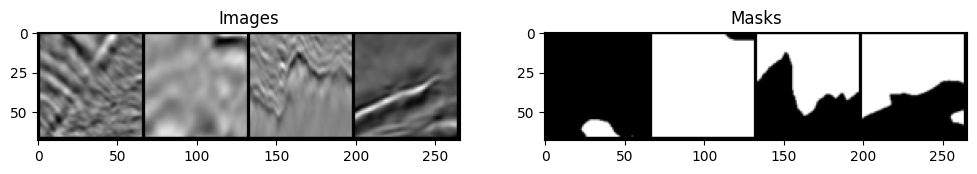

In [25]:

# Visualize the batch of images and masks
visualize_data(images, masks)

In [26]:
#instantiate train model

model = UNet(in_channels=3, out_channels=1)



In [27]:
#move model to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (middle): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): ConvTranspose2d(1, 1, kernel_size=(2, 2), strid

In [28]:
print(device)

cuda


In [29]:
#loss function with opt
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [30]:
#training loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, masks in train_loader:
        inputs = inputs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [31]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))

Epoch [1/20], Loss: 0.6394
Epoch [2/20], Loss: 0.6313
Epoch [3/20], Loss: 0.6237
Epoch [4/20], Loss: 0.6166
Epoch [5/20], Loss: 0.6040
Epoch [6/20], Loss: 0.5915
Epoch [7/20], Loss: 0.5797
Epoch [8/20], Loss: 0.5656
Epoch [9/20], Loss: 0.5566
Epoch [10/20], Loss: 0.5395
Epoch [11/20], Loss: 0.5294
Epoch [12/20], Loss: 0.5252
Epoch [13/20], Loss: 0.5137
Epoch [14/20], Loss: 0.5047
Epoch [15/20], Loss: 0.4957
Epoch [16/20], Loss: 0.4939
Epoch [17/20], Loss: 0.4850
Epoch [18/20], Loss: 0.4736
Epoch [19/20], Loss: 0.4855
Epoch [20/20], Loss: 0.4714


In [32]:
# Save the trained model
torch.save(model.state_dict(), 'unet_model.pth')

In [34]:
# Load the trained model
model = UNet(in_channels=3, out_channels=1)  # Replace with appropriate parameters
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (middle): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): ConvTranspose2d(1, 1, kernel_size=(2, 2), strid

In [35]:
# Load the sample image from test set
sample_image = Image.open('0a0cc52eca.png') # Replace with the path to your sample image
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
sample_image = transform(sample_image).unsqueeze(0)


In [36]:
# Evaluate the model on the sample image
with torch.no_grad():
    output = model(sample_image)
    predicted_mask = torch.sigmoid(output)
    predicted_mask[predicted_mask > 0.5] = 1  # Convert predicted mask to binary (0 or 1)
    predicted_mask[predicted_mask <= 0.5] = 0


In [37]:
# Convert predicted mask to numpy array
predicted_mask = predicted_mask.squeeze(0).squeeze(0).numpy()


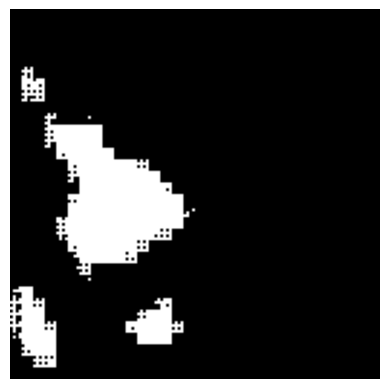

In [38]:
# Display the predicted mask
import matplotlib.pyplot as plt
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')
plt.show()

2. Training model using depth information

In [3]:
from skimage.io import imread
from skimage.transform import resize

In [4]:
class SaltDataset(Dataset):
    def __init__(self, df, image_dir, image_size=128):
        self.df = df
        self.image_dir = image_dir
        self.image_size = image_size

    def __getitem__(self, index):
      img_id = self.df.iloc[index]["id"]
      img_path = self.image_dir+"images/" + img_id + ".png"
      image = imread(img_path)
      image = resize(image, (self.image_size, self.image_size), mode="constant", anti_aliasing=False)
      image = torch.from_numpy(image).type(torch.FloatTensor).unsqueeze(0)  # Add unsqueeze to create batch dimension
      depth = torch.from_numpy(np.array([self.df.iloc[index]["z"]])).type(torch.FloatTensor)
      mask = torch.from_numpy(np.expand_dims(imread(self.image_dir + "masks/" + img_id + ".png").astype(np.uint8), axis=0)).type(torch.FloatTensor)  # Load mask image using imread and convert to uint8
      return image, mask, depth

    def __len__(self):
        return len(self.df)


In [24]:
class UNetDepth(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNetDepth, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc5 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(128, 64,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.outconv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, depth):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        # Decoder
        upconv1 = self.upconv1(enc5)
        dec1 = self.dec1(torch.cat((upconv1, enc4), dim=1))
        upconv2 = self.upconv2(dec1)
        dec2 = self.dec2(torch.cat((upconv2, enc3), dim=1))
        upconv3 = self.upconv3(dec2)
        dec3 = self.dec3(torch.cat((upconv3, enc2), dim=1))
        upconv4 = self.upconv4(dec3)
        dec4 = self.dec4(torch.cat((upconv4, enc1), dim=1))

        # Output
        output = self.outconv(dec4)
        return output

In [25]:
train_df = pd.read_csv("/content/drive/MyDrive/Datasets/dataset/train.csv")
depth_df = pd.read_csv("/content/drive/MyDrive/Datasets/dataset/depths.csv")

In [26]:
depth_df

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783
...,...,...
21995,09f1675cfb,400
21996,6947dbc4f4,804
21997,68de95fb39,605
21998,fdad2f99d8,309


In [27]:
train_df = train_df.merge(depth_df, on="id", how="left")
train_dataset = SaltDataset(train_df, "/content/drive/MyDrive/Datasets/dataset/train/")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [28]:
for batch in train_loader:
  print(batch[0].shape,batch[1].shape,batch[2].shape)
  break

torch.Size([64, 1, 128, 128, 3]) torch.Size([64, 1, 101, 101]) torch.Size([64, 1])


In [29]:
num_epochs=20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = UNetDepth(in_channels=3,out_channels=1).to(device)

cuda


In [30]:
import torch.nn.functional as F
# Define the training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (images, masks, depths) in enumerate(train_loader):
        images, masks, depths = images.to(device), masks.to(device), depths.to(device)
        optimizer.zero_grad()
        images = images.squeeze(1)
        images = images.permute(0, 3, 1, 2)

        #print(masks.shape)
        # Resize the target tensor to match the spatial dimensions of the output tensor
        masks = F.interpolate(masks, size=(128, 128), mode='bilinear', align_corners=False)

        depths = depths.squeeze(1)
        outputs = model(images, depths)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

In [31]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define the BCEWithLogitsLoss criterion
criterion = nn.BCEWithLogitsLoss()



In [ ]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))

Epoch [1/20], Loss: -908165808589074268684288.0000


High negative BCE loss suggests that model's prediction for the positive class is far off from the actual positive class label, and the model needs to be updated to improve its accuracy.

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'unet_depth_model.pth')